In [1]:
from SimPEG import np, sp, EM, Mesh
from SimPEG.EM.Static import DC

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Modified Pole-Pole array

In [3]:
def getDCdata(fname, offset=0.):
    fid = open(fname, "rb")
    lines = fid.readlines()
    n = int(np.array(map(float, lines[5].split())) [0])
    nelecl = int(np.array(map(float, lines[5].split())) [1])
    nelec = nelecl+3
    i_n = 0
    data = []
    print n, nelec
    for iline, line in enumerate(lines[6:]):
        temp = np.array(map(float, line.split()))
        data.append(temp)
        if temp.size is not 10:
            i_n += 1
        if i_n == n:
#             aspacing =  float(lines[6+iline+1].split()[1])
            break
    data = np.hstack(data)
    fid.close()

    ndata = data.size
    B = []
    M = []
    for i_n in range(n):
        tempB = np.array(np.arange(nelecl-i_n)+1)
        tempM = np.array(np.arange(nelecl-i_n)+2+i_n)
        B.append(tempB)
        M.append(tempM)    
    B = np.hstack(B) 
    M = np.hstack(M) 
    A = np.ones(ndata, dtype=int) 
    N = np.ones(ndata, dtype=int) * (nelec-1) 
    
    aspacing = 5. 
    uniqB = np.unique(B)
    srcList = []
    dobsres = []
    for isrc in range (nelecl):
        locA = np.r_[0.+offset, 0., 0.]
        locB = np.r_[uniqB[isrc]*aspacing+offset, 0., 0.]
        rxinds = B == uniqB[isrc]
        locsM = np.c_[M[rxinds]*aspacing+offset, np.zeros(rxinds.sum()), np.zeros(rxinds.sum())]
        locsN = np.c_[N[rxinds]*aspacing+offset, np.zeros(rxinds.sum()), np.zeros(rxinds.sum())]    
        rx = DC.Rx.Dipole(locsM, locsN)
        src = DC.Src.Dipole([rx], locA, locB)
        srcList.append(src)
        dobsres.append(data[rxinds])
    dobsres = np.hstack(dobsres)
    survey = DC.Survey(srcList)
    survey.dobs = dobsres
    
    return survey

In [4]:
fname2007 = "../data/ChungCheonDC/20150101000000.apr"
fname2015 = "../data/ChungCheonDC/20150501000000.apr"
survey2007 = getDCdata(fname2007)

3 5


/Users/sklim/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:43: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 15 but corresponding boolean dimension is 3
/Users/sklim/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:47: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 15 but corresponding boolean dimension is 3


In [5]:
survey2015 = getDCdata(fname2015, offset=-10.)

3 5


/Users/sklim/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:43: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 15 but corresponding boolean dimension is 3
/Users/sklim/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:47: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 15 but corresponding boolean dimension is 3


TypeError: plot_pseudoSection() got an unexpected keyword argument 'dtype'

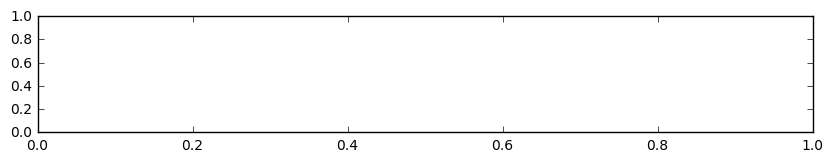

In [6]:
fig, ax = plt.subplots(1,1, figsize=(10,1.5))
out = EM.Static.Utils.plot_pseudoSection(survey2007, ax, sameratio=False, dtype="volt", clim=(0.7, 80))
geom = np.hstack(out[3])
dobs2007 = survey2007.dobs*geom
ax.set_xlim(80, 280)

TypeError: plot_pseudoSection() got an unexpected keyword argument 'dtype'

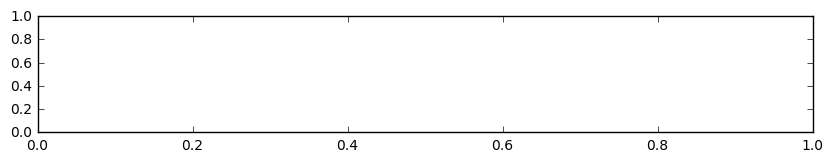

In [7]:
fig, ax = plt.subplots(1,1, figsize=(10,1.5))
out = EM.Static.Utils.plot_pseudoSection(survey2015, ax, sameratio=False, dtype="volt", clim=(0.7, 80))
geom = np.hstack(out[3])
temp = survey2015.dobs.copy()
temp [temp <= 0.] = np.nan
dobs2015 = temp*geom
ax.set_xlim(80, 280)

NameError: name 'temp' is not defined

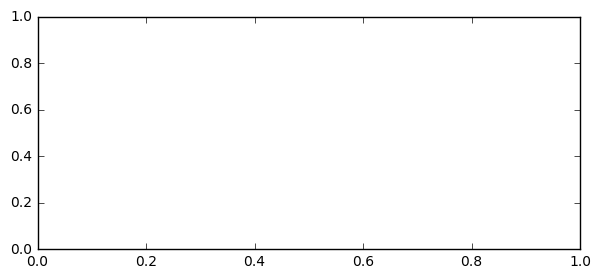

In [8]:
fig, ax = plt.subplots(1,1, figsize=(7,3))
out = hist(np.log10(temp[~np.isnan(temp)]), bins=100, color='b', alpha=0.5)
out = hist(np.log10(survey2007.dobs), bins=100, color='r', alpha=0.3)
ax.grid(True)
ax.legend(("2007", "2015"))

In [9]:
from SimPEG.Survey import Data
def removeRxsfromDC(survey, inds, DClow=-np.inf, DChigh=np.inf, surveyType="2D"):
    srcList = survey.srcList
    srcListNew = []
    dobs = survey.dobs
    dobs[inds] = np.nan
    data = Data(survey, survey.dobs)
    rxData = []
    for iSrc, src in enumerate(srcList):
        rx = src.rxList[0]
        data_temp = data[src, rx]        
        rxinds = np.isnan(data_temp) | (np.logical_or(DClow>data_temp, DChigh<data_temp))
        nrxact_temp = rxinds.sum()
        nrx_temp = len(rxinds)
        rxlocM = rx.locs[0]
        rxlocN = rx.locs[1]
        srcloc = src.loc
        rxData.append(data_temp[~rxinds])
        # All Rxs are active
        if  nrxact_temp == 0:
            if surveyType == "2D":                
                rxNew = DC.Rx.Dipole_ky(rxlocM, rxlocN)
            else:
                rxNew = DC.Rx.Dipole(rxlocM, rxlocN)
            srcNew = DC.Src.Dipole([rxNew], srcloc[0], srcloc[1])                        
            srcListNew.append(srcNew)            
        # All Rxs are nan then remove src
        elif nrx_temp == nrxact_temp:
            print ("Remove %i-th Src") % (iSrc)
        # Some Rxs are not active
        else:
            if surveyType == "2D":                
                rxNew = DC.Rx.Dipole_ky(rxlocM[~rxinds,:], rxlocN[~rxinds,:])
            else:
                rxNew = DC.Rx.Dipole(rxlocM[~rxinds,:], rxlocN[~rxinds,:])
            srcNew = DC.Src.Dipole([rxNew], srcloc[0], srcloc[1])                        
            srcListNew.append(srcNew)
    if surveyType == "2D":                            
        surveyNew = DC.Survey_ky(srcListNew)
    else:
        surveyNew = DC.Survey(srcListNew)                          
    surveyNew.dobs = np.hstack(rxData)
    return surveyNew

def from3Dto2Dsurvey(survey):
    srcLists2D = []
    nSrc = len(survey.srcList)

    for iSrc in range (nSrc):
        src = survey.srcList[iSrc]
        locsM = np.c_[src.rxList[0].locs[0][:,0], np.ones_like(src.rxList[0].locs[0][:,0])*-0.75] 
        locsN = np.c_[src.rxList[0].locs[1][:,0], np.ones_like(src.rxList[0].locs[1][:,0])*-0.75] 
        rx = DC.Rx.Dipole_ky(locsM, locsN)
        locA = np.r_[src.loc[0][0], -0.75]
        locB = np.r_[src.loc[1][0], -0.75]
        src = DC.Src.Dipole([rx], locA, locB)
        srcLists2D.append(src)
    survey2D = DC.Survey_ky(srcLists2D)
    survey2D.dobs = survey.dobs.copy()
    return survey2D

(80, 280)

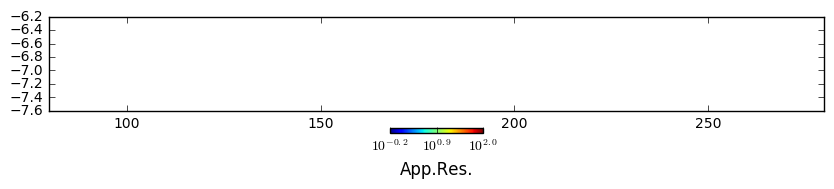

In [10]:
survey2007.dobs = dobs2007
fig, ax = plt.subplots(1,1, figsize=(10,1.5))
out = EM.Static.Utils.plot_pseudoSection(survey2007, ax, sameratio=False, dtype="appr", scale="log", clim=(-0.2, 2))
ax.set_xlim(80, 280)

(80, 280)

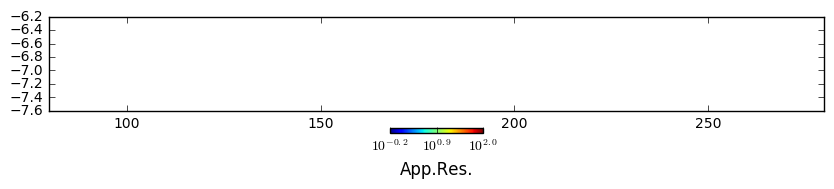

In [11]:
survey2015.dobs = dobs2015
survey2015New = removeRxsfromDC(survey2015, [])
fig, ax = plt.subplots(1,1, figsize=(10,1.5))
out = EM.Static.Utils.plot_pseudoSection(survey2015New, ax, sameratio=False, dtype="appr", scale="log", clim=(-0.2, 2))
ax.set_xlim(80, 280)

In [12]:
cs = 2.5
npad = 6
hx = [(cs,npad, -1.3),(cs,150),(cs,npad, 1.3)]
hy = [(cs,npad, -1.3),(cs,20),(cs/2, 5)]
mesh = Mesh.TensorMesh([hx, hy])
mesh = Mesh.TensorMesh([hx, hy],x0=[-mesh.hx[:6].sum()-0.25-10, -mesh.hy.sum()])

In [13]:
from SimPEG import (Mesh, Maps, Utils, DataMisfit, Regularization,
                    Optimization, Inversion, InvProblem, Directives)
from pymatsolver import PardisoSolver

ImportError: No module named pymatsolver

In [ ]:
mapping = Maps.ExpMap(mesh)
survey2D = from3Dto2Dsurvey(survey2015New)
problem = DC.Problem2D_N(mesh, mapping=mapping)
problem.pair(survey2D)
problem.Solver = PardisoSolver
m0 = np.ones(mesh.nC)*np.log(1e-1)
mref = np.ones(mesh.nC)*np.log(1e-2)

In [ ]:
# from ipywidgets import interact
# nSrc = len(survey2D.srcList)
# def foo(isrc):
#     figsize(10, 5)
#     mesh.plotImage(np.ones(mesh.nC)*np.nan, gridOpts={"color":"k", "alpha":0.5}, grid=True)
# #     isrc=0
#     src = survey2D.srcList[isrc]
#     plt.plot(src.loc[0][0], src.loc[0][1], 'bo')
#     plt.plot(src.loc[1][0], src.loc[1][1], 'ro')
#     locsM = src.rxList[0].locs[0]
#     locsN = src.rxList[0].locs[1]
#     plt.plot(locsM[:,0], locsM[:,1], 'ko')
#     plt.plot(locsN[:,0], locsN[:,1], 'go')
#     plt.gca().set_aspect('equal', adjustable='box')
    
# interact(foo, isrc=(0, nSrc-1, 1))

In [ ]:
weight =  1./abs(mesh.gridCC[:,1])**1.5

In [ ]:
survey2D.eps = 10**(-2.5)
survey2D.std = 0.02
dmisfit = DataMisfit.l2_DataMisfit(survey2D)
regmap = Maps.IdentityMap(nP=int(mesh.nC))
reg = Regularization.Simple(mesh,mapping=regmap)
# reg = Regularization.Simple(mesh,mapping=regmap,cell_weights=weight)
opt = Optimization.ProjectedGNCG(maxIter=10)
opt.upper = np.log(1e0)
opt.lower = np.log(1e-3)
invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
# Create an inversion object
beta = Directives.BetaSchedule(coolingFactor=5, coolingRate=2)
betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1e0)
inv = Inversion.BaseInversion(invProb, directiveList=[beta, betaest])
problem.counter = opt.counter = Utils.Counter()
opt.LSshorten = 0.5
opt.remember('xc')
reg.mref = mref
mopt = inv.run(m0)

In [ ]:
# sigma = np.ones(mesh.nC)
sigma = mapping*mopt
modelname = "sigma2015_lakeside.npy"
np.save(modelname, sigma)

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (20, 1.5))
sigma = mapping*mopt
dat = mesh.plotImage(np.log10(1./sigma), grid=False, ax=ax, pcolorOpts={"cmap":"jet"}, clim=(0, 3))
ax.set_ylim(-15, 0)
ax.set_xlim(-10, 380)
plt.colorbar(dat[0], ax=ax)
plt.plot(np.r_[1, 1]*342, np.r_[-20, 20], lw=3)